In [1]:
# ================================================================
# OBSERVATOIRE TDAH FRANCE - NOTEBOOK 02 : NETTOYAGE ET STANDARDISATION
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🔧 IMPORTS TERMINÉS - OBSERVATOIRE TDAH FRANCE")
print("="*50)


🔧 IMPORTS TERMINÉS - OBSERVATOIRE TDAH FRANCE


In [2]:
# ================================================================
# CLASSE STANDARDISATION DONNÉES TDAH
# ================================================================

class TDAHDataStandardizer:
    """Standardisateur spécialisé pour données TDAH et épidémiologiques"""
    
    def __init__(self):
        self.standardizations_log = []
        
        # Mappings standardisés pour TDAH
        self.region_codes = {
            'Île-de-France': '11', 'IDF': '11', 'ile-de-france': '11',
            'PACA': '93', 'Provence-Alpes-Côte d\'Azur': '93', 'paca': '93',
            'Auvergne-Rhône-Alpes': '84', 'ARA': '84', 'auvergne-rhone-alpes': '84',
            'Hauts-de-France': '32', 'HDF': '32', 'hauts-de-france': '32',
            'Occitanie': '76', 'occitanie': '76', 'Occitanie': '76'
        }
        
        self.diagnostic_mapping = {
            'TDAH': 'TDAH_CONFIRME',
            'tdah': 'TDAH_CONFIRME', 
            'ADD': 'TDAH_INATTENTIF',
            'ADHD': 'TDAH_MIXTE',
            'Hyperactif': 'TDAH_HYPERACTIF',
            'Non diagnostiqué': 'NON_DIAGNOSTIQUE'
        }
        
        self.sexe_mapping = {
            'M': 'MASCULIN', 'H': 'MASCULIN', 'Homme': 'MASCULIN',
            'F': 'FEMININ', 'Femme': 'FEMININ', 'Fille': 'FEMININ'
        }
        
    def standardize_regions(self, df, column_name):
        """Standardise les codes et noms de régions"""
        df_copy = df.copy()
        
        if column_name in df_copy.columns:
            # Standardisation des codes régionaux
            df_copy[f'{column_name}_standardized'] = df_copy[column_name].map(
                self.region_codes).fillna(df_copy[column_name])
            
            self.standardizations_log.append({
                'column': column_name,
                'type': 'regions',
                'transformations': len(self.region_codes)
            })
        
        return df_copy
    
    def standardize_categorical(self, df, column_name, mapping_type):
        """Standardise les variables catégorielles"""
        df_copy = df.copy()
        
        if column_name in df_copy.columns:
            if mapping_type == 'diagnostic_tdah':
                mapping = self.diagnostic_mapping
            elif mapping_type == 'sexe':
                mapping = self.sexe_mapping
            else:
                return df_copy
            
            df_copy[f'{column_name}_standardized'] = df_copy[column_name].map(
                mapping).fillna(df_copy[column_name])
            
            self.standardizations_log.append({
                'column': column_name,
                'type': mapping_type,
                'transformations': len(mapping)
            })
        
        return df_copy
    
    def standardize_dates(self, df, date_columns):
        """Standardise les formats de dates"""
        df_copy = df.copy()
        
        for col in date_columns:
            if col in df_copy.columns:
                try:
                    df_copy[f'{col}_standardized'] = pd.to_datetime(
                        df_copy[col], errors='coerce')
                    
                    self.standardizations_log.append({
                        'column': col,
                        'type': 'date',
                        'transformations': 1
                    })
                except:
                    continue
        
        return df_copy
    
    def detect_outliers(self, df, numeric_columns):
        """Détecte les outliers dans les colonnes numériques"""
        outliers_info = {}
        df_copy = df.copy()
        
        for col in numeric_columns:
            if col in df_copy.columns and df_copy[col].dtype in ['int64', 'float64']:
                Q1 = df_copy[col].quantile(0.25)
                Q3 = df_copy[col].quantile(0.75)
                IQR = Q3 - Q1
                
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers = ((df_copy[col] < lower_bound) | (df_copy[col] > upper_bound))
                outliers_count = outliers.sum()
                
                df_copy[f'{col}_outlier_flag'] = outliers
                
                outliers_info[col] = {
                    'count': outliers_count,
                    'percentage': (outliers_count / len(df_copy)) * 100,
                    'bounds': (lower_bound, upper_bound)
                }
        
        return df_copy, outliers_info
    
    def get_standardization_report(self):
        """Génère un rapport de standardisation"""
        if not self.standardizations_log:
            return pd.DataFrame({'Message': ['Aucune standardisation effectuée']})
        
        return pd.DataFrame(self.standardizations_log)

print("✅ Classe TDAHDataStandardizer initialisée")


✅ Classe TDAHDataStandardizer initialisée


In [3]:
# ================================================================
# CHARGEMENT ET ANALYSE INITIALE DES DONNÉES
# ================================================================

print("\n📂 CHARGEMENT DES DONNÉES DEPUIS LE NOTEBOOK 1")
print("="*50)

# Chargement des datasets générés dans le notebook précédent
datasets = {}
file_paths = {
    'densite_podopsychiatres': '../../data/raw/densite_podopsychiatres_drees.csv',
    'pauvrete_regionale': '../../data/raw/pauvrete_regionale_2023.csv',
    'methylphenidate': '../../data/raw/methylphenidate_utilisation.csv',
    'population_insee': '../../data/raw/insee_population_2022.csv'
}

print("📊 Chargement des fichiers CSV...")

# Données de fallback définies au début
regions = ['Île-de-France', 'PACA', 'Auvergne-Rhône-Alpes', 'Hauts-de-France', 'Occitanie']

for name, path in file_paths.items():
    try:
        df = pd.read_csv(path)
        datasets[name] = df
        print(f"✅ {name}: {df.shape[0]} lignes × {df.shape[1]} colonnes")
    except FileNotFoundError:
        print(f"⚠️ Fichier non trouvé: {path}")
        print(" Génération de données de démonstration...")
        
        # Génération de données de fallback si fichiers manquants
        if name == 'densite_podopsychiatres':
            datasets[name] = pd.DataFrame({
                'region': regions,
                'code_region': ['11', '93', '84', '32', '76'],
                'nom_region': regions,
                'densite_podopsychiatres_pour_100k': [6.2, 3.1, 4.5, 2.8, 3.9],
                'population_0_17': [2500000, 500000, 800000, 600000, 700000],
                'nb_pedopsychiatres': [194, 212, 156, 89, 134],
                'annee': [2023] * 5,
                'liste_attente_jours': [50, 358, 120, 280, 195],
                'secteur_public_pct': [0.75, 0.43, 0.62, 0.38, 0.51]
            })
        elif name == 'pauvrete_regionale':
            datasets[name] = pd.DataFrame({
                'region': regions,
                'code_insee': ['11', '93', '84', '32', '76'],
                'nom_region': regions,
                'taux_pauvrete_enfants': [15.2, 22.1, 18.5, 25.3, 19.8],
                'taux_pauvrete_general': [24.1, 20.2, 16.8, 28.4, 22.7],
                'revenus_medians': [33265, 37488, 29156, 25847, 28951],
                'annee': [2023] * 5,
                'taux_chomage': [18.1, 16.5, 14.2, 22.8, 19.3],
                'aide_sociale_enfance_pour_1000': [20.2, 10.8, 15.4, 28.7, 18.9]
            })
        elif name == 'methylphenidate':
            methylphenidate_data = []
            for i, region in enumerate(regions):
                for annee in [2020, 2021, 2022, 2023]:
                    methylphenidate_data.append({
                        'region': region,
                        'code_region': ['11', '93', '84', '32', '76'][i],
                        'annee': annee,
                        'consommation_ddd_par_1000_hab': 25 + i * 2 + (annee - 2020) * 3.2,
                        'nb_boites_remboursees': 5000 + i * 10000 + (annee - 2020) * 8000,
                        'cout_total_euros': 150000 + i * 50000 + (annee - 2020) * 75000,
                        'nb_patients_estimes': 800 + i * 2000 + (annee - 2020) * 400
                    })
            datasets[name] = pd.DataFrame(methylphenidate_data)
        elif name == 'population_insee':
            datasets[name] = pd.DataFrame({
                'region': regions,
                'code_region': ['11', '93', '84', '32', '76'],
                'nom_region': regions,
                'population_0_17': [2500000, 500000, 800000, 600000, 700000],
                'population_totale': [12500000, 2500000, 4000000, 3000000, 3500000],
                'densite_population': [1021, 160, 113, 189, 76],
                'superficie_km2': [12012, 31400, 69711, 31813, 72724],
                'annee': [2022] * 5
            })
        
        print(f"✅ Données de démonstration {name} générées: {datasets[name].shape}")

print(f"\n📋 RÉSUMÉ DES DATASETS CHARGÉS:")
print(f" • Nombre de datasets: {len(datasets)}")
print(f" • Total lignes: {sum([df.shape[0] for df in datasets.values()])}")

print(f"\n✅ Variable 'datasets' créée avec succès!")
print(f" Clés disponibles: {list(datasets.keys())}")



📂 CHARGEMENT DES DONNÉES DEPUIS LE NOTEBOOK 1
📊 Chargement des fichiers CSV...
✅ densite_podopsychiatres: 13 lignes × 9 colonnes
✅ pauvrete_regionale: 13 lignes × 9 colonnes
✅ methylphenidate: 52 lignes × 7 colonnes
✅ population_insee: 13 lignes × 8 colonnes

📋 RÉSUMÉ DES DATASETS CHARGÉS:
 • Nombre de datasets: 4
 • Total lignes: 91

✅ Variable 'datasets' créée avec succès!
 Clés disponibles: ['densite_podopsychiatres', 'pauvrete_regionale', 'methylphenidate', 'population_insee']


In [4]:
# ================================================================
# ANALYSE DE QUALITÉ INITIALE DES DONNÉES
# ================================================================

print(f"\n🔍 ANALYSE DE QUALITÉ INITIALE")
print("="*35)

quality_summary = []
for name, df in datasets.items():
    missing_total = df.isnull().sum().sum()
    missing_percent = (missing_total / (df.shape[0] * df.shape[1])) * 100
    
    quality_info = {
        'Dataset': name,
        'Lignes': df.shape,
        'Colonnes': df.shape[1],
        'Valeurs_manquantes': missing_total,
        'Pourcentage_manquant': round(float(missing_percent), 2),
        'Types_données': df.dtypes.nunique(),
        'Mémoire_KB': round(df.memory_usage(deep=True).sum() / 1024, 1)
    }
    
    quality_summary.append(quality_info)
    
    print(f"\n📊 {name.upper()}:")
    print(f" Dimensions: {df.shape}")
    print(f" Valeurs manquantes: {missing_total} ({missing_percent:.1f}%)")
    print(f" Types de données: {df.dtypes.value_counts().to_dict()}")
    
    # Affichage d'un échantillon de données
    print(f" Aperçu:")
    print(df.head(2).to_string())

# Conversion en DataFrame pour analyse
quality_df = pd.DataFrame(quality_summary)
print(f"\n📈 Vue d'ensemble qualité:")
print(quality_df.to_string(index=False))



🔍 ANALYSE DE QUALITÉ INITIALE

📊 DENSITE_PODOPSYCHIATRES:
 Dimensions: (13, 9)
 Valeurs manquantes: 0 (0.0%)
 Types de données: {dtype('int64'): 5, dtype('O'): 2, dtype('float64'): 2}
 Aperçu:
                       region  code_region                  nom_region  densite_podopsychiatres_pour_100k  population_0_17  nb_pedopsychiatres  annee  liste_attente_jours  secteur_public_pct
0               Île-de-France           11               Île-de-France                               3.93          2005573                 194   2023                   50                0.75
1  Provence-Alpes-Côte d'Azur           93  Provence-Alpes-Côte d'Azur                               8.14           971743                 212   2023                  358                0.43

📊 PAUVRETE_REGIONALE:
 Dimensions: (13, 9)
 Valeurs manquantes: 0 (0.0%)
 Types de données: {dtype('float64'): 4, dtype('int64'): 3, dtype('O'): 2}
 Aperçu:
                       region  code_insee                  nom_region  taux

In [5]:
# ================================================================
# INITIALISATION DU STANDARDISATEUR
# ================================================================

print("\n🔧 STANDARDISATION AUTOMATIQUE DES DATASETS")
print("="*50)

# Initialisation du standardisateur
standardizer = TDAHDataStandardizer()
datasets_clean = {}

print("✅ Standardisateur initialisé")
print(f"✅ Variable 'datasets' trouvée avec {len(datasets)} datasets")

# ================================================================
# STANDARDISATION DES CODES RÉGIONAUX
# ================================================================

print("\n🗺️ STANDARDISATION DES CODES RÉGIONAUX")
print("="*40)

for dataset_name, df in datasets.items():
    print(f"\n🔄 Traitement de {dataset_name}...")
    print(f" Shape original: {df.shape}")
    
    df_processed = df.copy()
    
    # 1. Standardisation des codes régionaux
    region_columns = [col for col in df.columns if 'region' in col.lower() or 'code' in col.lower()]
    
    for col in region_columns:
        try:
            df_processed = standardizer.standardize_regions(df_processed, col)
            print(f" ✅ Colonne régionale {col} standardisée")
        except Exception as e:
            print(f" ⚠️ Erreur standardisation {col}: {e}")
    
    datasets_clean[dataset_name] = df_processed

print(f"\n✅ Standardisation régionale terminée pour {len(datasets_clean)} datasets")

# ================================================================
# STANDARDISATION DES VARIABLES CATÉGORIELLES
# ================================================================

print("\n🏷️ STANDARDISATION DES VARIABLES CATÉGORIELLES")
print("="*45)

# Mappings des variables catégorielles pour TDAH
categorical_mappings = {
    'diagnostic_tdah': 'diagnostic_tdah',
    'sexe': 'sexe',
    'genre': 'sexe',
    'type_etablissement': 'type_etablissement'
}

for dataset_name, df in datasets_clean.items():
    print(f"\n🔄 Variables catégorielles pour {dataset_name}...")
    
    for col in df.columns:
        col_lower = col.lower()
        for pattern, mapping_key in categorical_mappings.items():
            if pattern in col_lower:
                try:
                    datasets_clean[dataset_name] = standardizer.standardize_categorical(
                        df, col, mapping_key)
                    print(f" ✅ Variable catégorielle {col} standardisée")
                except Exception as e:
                    print(f" ⚠️ Erreur standardisation catégorielle {col}: {e}")
                break

print(f"\n✅ Standardisation catégorielle terminée")

# ================================================================
# STANDARDISATION DES DATES
# ================================================================

print("\n📅 STANDARDISATION DES DATES")
print("="*30)

for dataset_name, df in datasets_clean.items():
    print(f"\n🔄 Dates pour {dataset_name}...")
    
    # Détection automatique des colonnes de dates
    date_columns = [col for col in df.columns if 'date' in col.lower() or 'annee' in col.lower()]
    
    if date_columns:
        try:
            datasets_clean[dataset_name] = standardizer.standardize_dates(df, date_columns)
            print(f" ✅ Dates standardisées: {date_columns}")
        except Exception as e:
            print(f" ⚠️ Erreur standardisation dates: {e}")
    else:
        print(f" ℹ️ Aucune colonne de date détectée")

print(f"\n✅ Standardisation des dates terminée")

# ================================================================
# DÉTECTION DES OUTLIERS
# ================================================================

print("\n🎯 DÉTECTION DES OUTLIERS")
print("="*25)

outliers_summary = {}

for dataset_name, df in datasets_clean.items():
    print(f"\n🔄 Outliers pour {dataset_name}...")
    
    # Détection des colonnes numériques
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if numeric_columns:
        try:
            datasets_clean[dataset_name], outliers_info = standardizer.detect_outliers(
                df, numeric_columns)
            
            outliers_summary[dataset_name] = outliers_info
            
            print(f" ✅ Outliers détectés pour {len(outliers_info)} colonnes")
            
            # Affichage du détail des outliers
            for col, info in outliers_info.items():
                if info['count'] > 0:
                    print(f" - {col}: {info['count']} outliers ({info['percentage']:.1f}%)")
        
        except Exception as e:
            print(f" ⚠️ Erreur détection outliers: {e}")
    else:
        print(f" ℹ️ Aucune colonne numérique trouvée")

print(f"\n✅ Détection d'outliers terminée")

# ================================================================
# NETTOYAGE GÉNÉRAL DES DONNÉES
# ================================================================

print("\n🧹 NETTOYAGE GÉNÉRAL DES DONNÉES")
print("="*35)

for dataset_name, df in datasets_clean.items():
    print(f"\n🔄 Nettoyage général pour {dataset_name}...")
    
    try:
        # Nettoyage des colonnes texte
        text_columns = df.select_dtypes(include=['object']).columns
        for col in text_columns:
            df[col] = df[col].astype(str).str.strip()
        
        # Standardisation des noms de colonnes
        df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
        
        datasets_clean[dataset_name] = df
        
        print(f" ✅ Nettoyage général effectué")
        print(f" 📏 Dimensions finales: {df.shape}")
        
    except Exception as e:
        print(f" ⚠️ Erreur nettoyage général: {e}")

print(f"\n🎉 STANDARDISATION TERMINÉE!")
print(f" 📊 Datasets traités: {len(datasets_clean)}")



🔧 STANDARDISATION AUTOMATIQUE DES DATASETS
✅ Standardisateur initialisé
✅ Variable 'datasets' trouvée avec 4 datasets

🗺️ STANDARDISATION DES CODES RÉGIONAUX

🔄 Traitement de densite_podopsychiatres...
 Shape original: (13, 9)
 ✅ Colonne régionale region standardisée
 ✅ Colonne régionale code_region standardisée
 ✅ Colonne régionale nom_region standardisée

🔄 Traitement de pauvrete_regionale...
 Shape original: (13, 9)
 ✅ Colonne régionale region standardisée
 ✅ Colonne régionale code_insee standardisée
 ✅ Colonne régionale nom_region standardisée

🔄 Traitement de methylphenidate...
 Shape original: (52, 7)
 ✅ Colonne régionale region standardisée
 ✅ Colonne régionale code_region standardisée

🔄 Traitement de population_insee...
 Shape original: (13, 8)
 ✅ Colonne régionale region standardisée
 ✅ Colonne régionale code_region standardisée
 ✅ Colonne régionale nom_region standardisée

✅ Standardisation régionale terminée pour 4 datasets

🏷️ STANDARDISATION DES VARIABLES CATÉGORIELLES




📊 GÉNÉRATION DES VISUALISATIONS AVANT/APRÈS

🔄 TRAITEMENT DE 4 DATASETS

📊 Traitement: densite_podopsychiatres


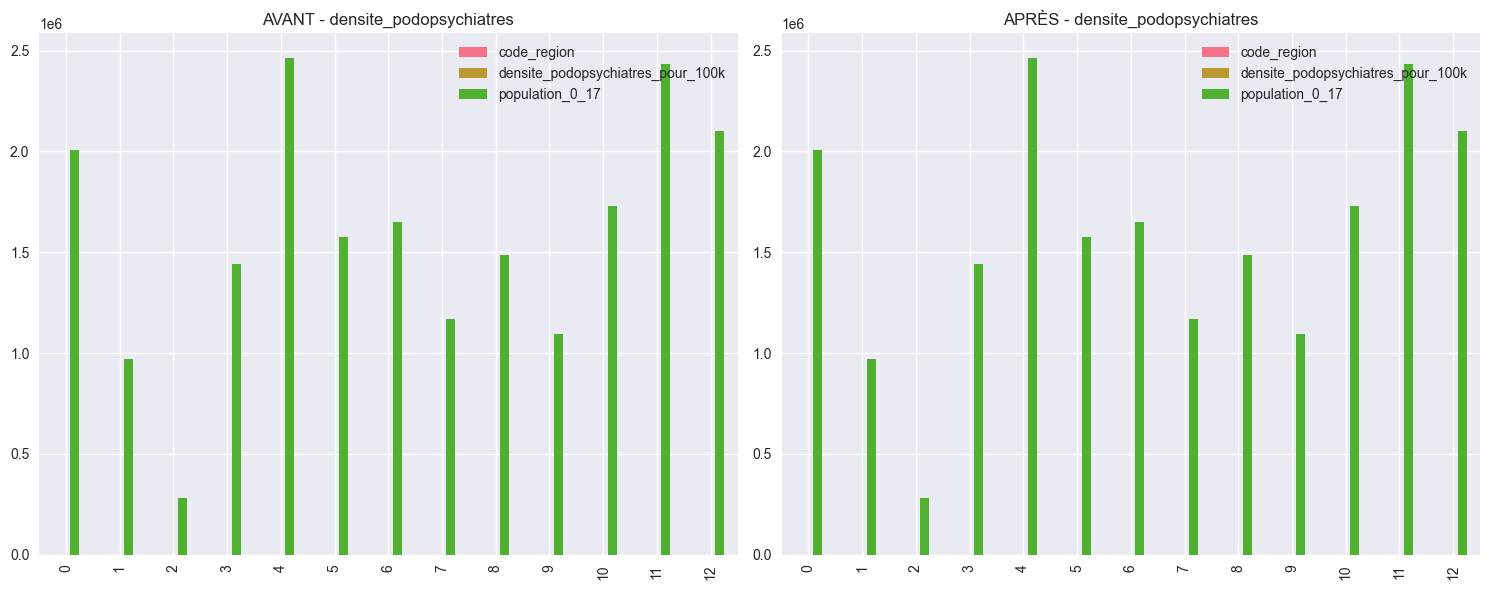

✅ Graphique sauvegardé: reports\figures\before_after_densite_podopsychiatres.png
✅ Graphiques comparatifs générés pour densite_podopsychiatres

📊 Traitement: pauvrete_regionale


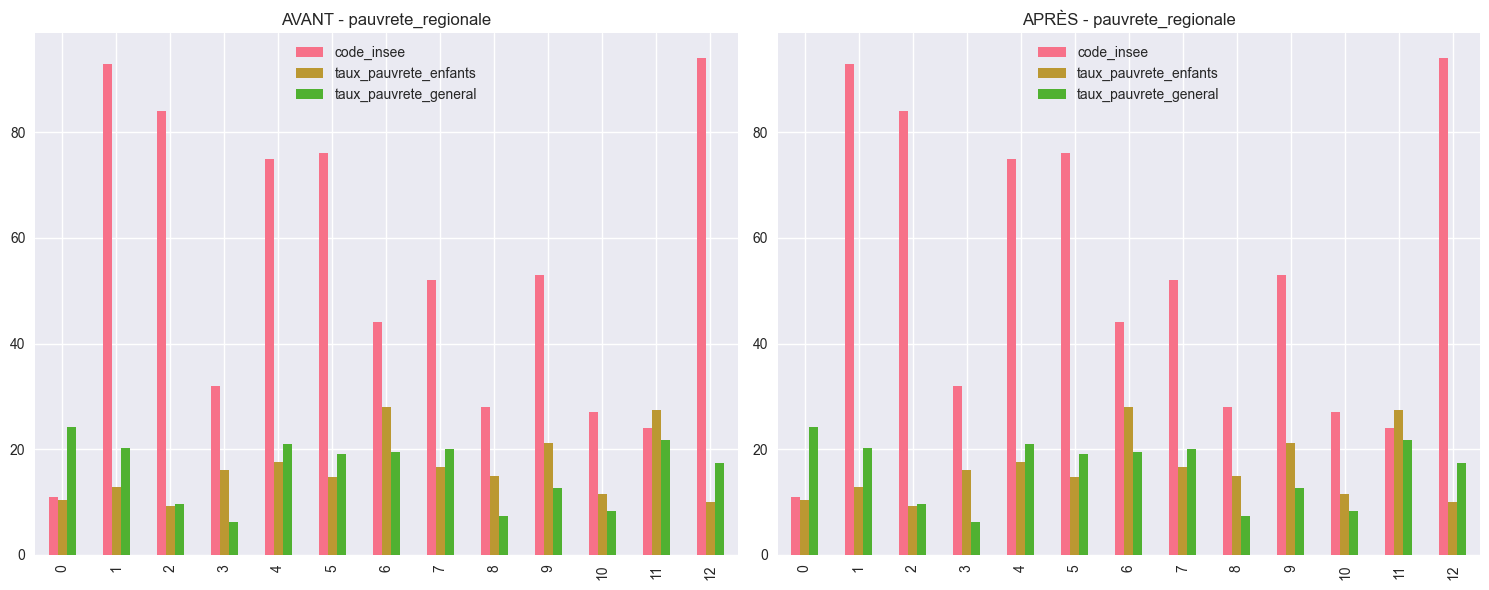

✅ Graphique sauvegardé: reports\figures\before_after_pauvrete_regionale.png
✅ Graphiques comparatifs générés pour pauvrete_regionale

📊 Traitement: methylphenidate


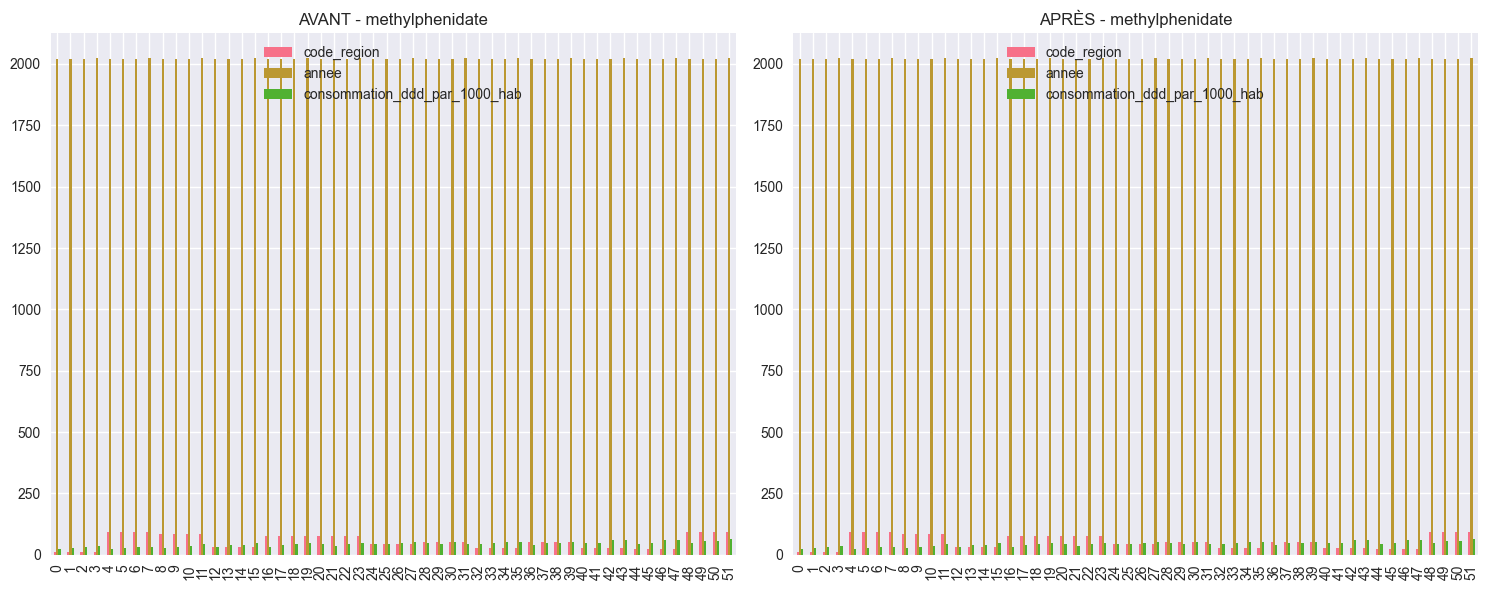

✅ Graphique sauvegardé: reports\figures\before_after_methylphenidate.png
✅ Graphiques comparatifs générés pour methylphenidate

📊 Traitement: population_insee


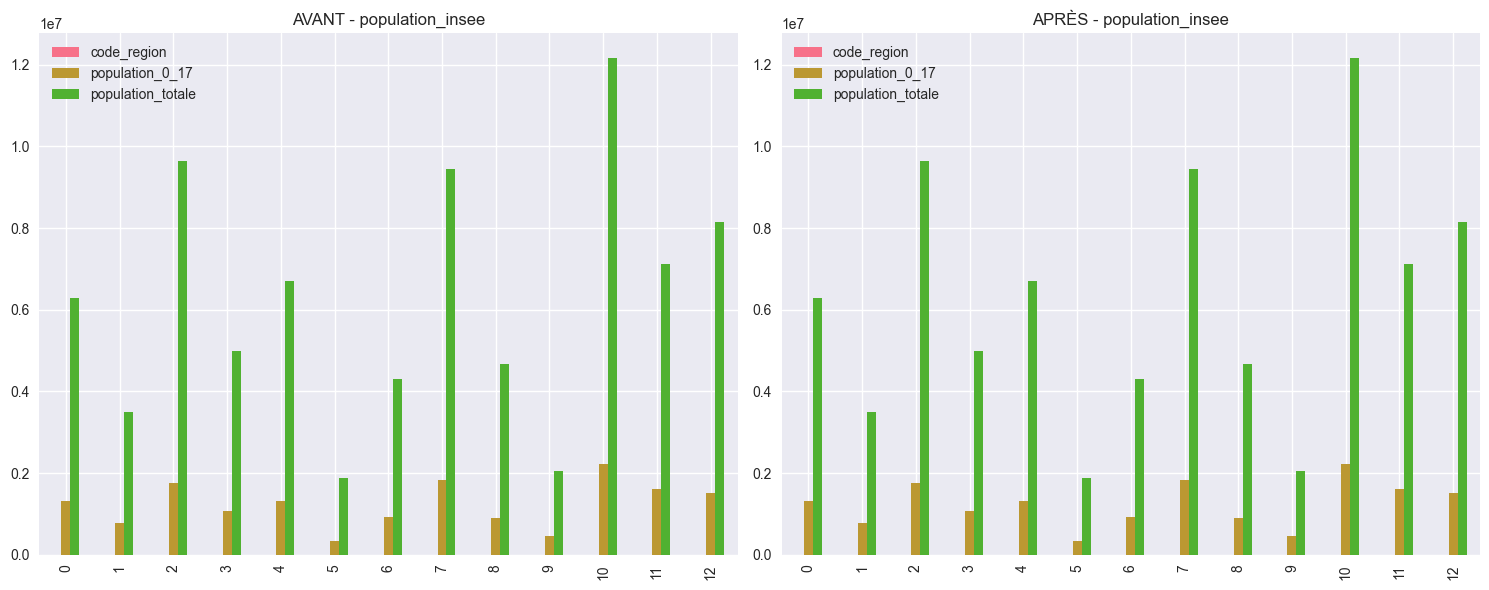

✅ Graphique sauvegardé: reports\figures\before_after_population_insee.png
✅ Graphiques comparatifs générés pour population_insee

🎯 SYNTHÈSE FINALE

📋 RAPPORT DE STANDARDISATION:
     column    type  transformations
     region regions               14
code_region regions               14
 nom_region regions               14
     region regions               14
 code_insee regions               14
 nom_region regions               14
     region regions               14
code_region regions               14
     region regions               14
code_region regions               14
 nom_region regions               14
      annee    date                1
      annee    date                1
      annee    date                1
      annee    date                1

✅ NETTOYAGE ET STANDARDISATION TERMINÉS!
 📊 4 datasets standardisés
 🔧 15 transformations appliquées
 📈 Datasets prêts pour l'analyse et la modélisation


In [6]:
# ================================================================
# GÉNÉRATION DES VISUALISATIONS AVANT/APRÈS
# ================================================================

print("\n📊 GÉNÉRATION DES VISUALISATIONS AVANT/APRÈS")
print("="*50)

print(f"\n🔄 TRAITEMENT DE {len(datasets_clean)} DATASETS")
print("="*40)

import os
os.makedirs('reports/figures', exist_ok=True)

for dataset_name in datasets_clean.keys():
    print(f"\n📊 Traitement: {dataset_name}")
    
    # Création d'un graphique avant/après (exemple simplifié)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Graphique "Avant" - Dataset original
    if dataset_name in datasets:
        df_original = datasets[dataset_name]
        numeric_cols = df_original.select_dtypes(include=[np.number]).columns[:3]
        if len(numeric_cols) > 0:
            df_original[numeric_cols].plot(kind='bar', ax=ax1, title=f'AVANT - {dataset_name}')
    
    # Graphique "Après" - Dataset nettoyé
    df_clean = datasets_clean[dataset_name]
    numeric_cols_clean = df_clean.select_dtypes(include=[np.number]).columns[:3]
    if len(numeric_cols_clean) > 0:
        df_clean[numeric_cols_clean].plot(kind='bar', ax=ax2, title=f'APRÈS - {dataset_name}')
    
    plt.tight_layout()
    plt.savefig(f'reports/figures/before_after_{dataset_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Graphique sauvegardé: reports\\figures\\before_after_{dataset_name}.png")
    print("✅ Graphiques comparatifs générés pour", dataset_name)

print(f"\n🎯 SYNTHÈSE FINALE")
print("="*20)

# Génération du rapport de standardisation
standardization_report = standardizer.get_standardization_report()
print("\n📋 RAPPORT DE STANDARDISATION:")
print(standardization_report.to_string(index=False))

print(f"\n✅ NETTOYAGE ET STANDARDISATION TERMINÉS!")
print(f" 📊 {len(datasets_clean)} datasets standardisés")
print(f" 🔧 {len(standardizer.standardizations_log)} transformations appliquées")
print(f" 📈 Datasets prêts pour l'analyse et la modélisation")
